In [1]:
from src.agent import *
import torch

In [2]:
critic = Critic(512, 128)

In [3]:
sum(torch.numel(param) for param in critic.parameters())

82817

In [4]:
values = critic(torch.randn(4, 512))

In [5]:
import torch

class ValueMemoryEMA:
    def __init__(self, alpha):
        """
        alpha: EMA factor (0 < alpha < 1)
        """
        self.alpha = alpha
        self.values = {}  # stores EMA per key

    def __call__(self, keys, vals):
        """
        keys: list of sample identifiers
        vals: torch.Tensor of shape (len(keys), D)
        Returns: new EMA values, old stored values
        """
        stored_list = []
        new_list = []

        for i, key in enumerate(keys):
            val = vals[i]
            if key not in self.values:
                # initialize first EMA as the current value
                self.values[key] = val.clone()
                old = torch.tensor([0])
            else:
                old = self.values[key]
                # EMA update
                self.values[key] = self.alpha * old + (1 - self.alpha) * val

            stored_list.append(old.unsqueeze(0))
            new_list.append(self.values[key].unsqueeze(0))

        stored = torch.cat(stored_list, dim=0)
        new = torch.cat(new_list, dim=0)
        return new, stored

    def get(self, key):
        """
        Access the current EMA for a single key
        """
        return self.values.get(key, None)

    def get_multi(self, keys):
        """
        Access current EMA for multiple keys
        """
        return torch.stack([self.values[k] for k in keys])

memory = ValueMemoryEMA(0.5)

In [6]:
memory(keys=["1", "2", "3", "4"], vals=values)

(tensor([[-0.2668],
         [ 0.0068],
         [ 0.1129],
         [ 0.1181]], grad_fn=<CatBackward0>),
 tensor([[0],
         [0],
         [0],
         [0]]))

In [7]:
memory.get_multi(["1", "2", "3", "4"])

tensor([[-0.2668],
        [ 0.0068],
        [ 0.1129],
        [ 0.1181]], grad_fn=<StackBackward0>)

In [8]:
from src.dataset import *
from torch.utils.data import DataLoader
from glob import glob
dataset,_  = get_dataset(glob("data/train/*.tar"), train=True)

In [42]:
key, img, label = sample

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9254032].


20018044_007_000


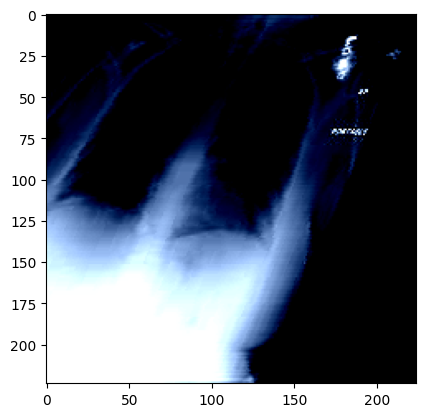

In [84]:
import matplotlib.pyplot as plt
sample = next(iter(dataset))
key, img, label = sample
print(key)
plt.imshow(img.permute(1,2,0))

In [26]:
import timm
from torchvision import models
import torch
import torch.nn as nn

convnext = models.convnext_tiny()

sum(torch.numel(param) for param in convnext.parameters())

convnext.classifier[2] = nn.Linear(in_features=768, out_features=14)

convnext

ConvNeXt(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU(approximate='none')
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=

In [32]:
swin = timm.create_model(
    "swin_s3_tiny_224",
    pretrained=True,
    num_classes=14
)

sum(torch.numel(param) for param in swin.parameters())

swin

SwinTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
    (norm): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
  )
  (layers): Sequential(
    (0): SwinTransformerStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): SwinTransformerBlock(
          (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (attn): WindowAttention(
            (qkv): Linear(in_features=96, out_features=288, bias=True)
            (attn_drop): Dropout(p=0.0, inplace=False)
            (proj): Linear(in_features=96, out_features=96, bias=True)
            (proj_drop): Dropout(p=0.0, inplace=False)
            (softmax): Softmax(dim=-1)
          )
          (drop_path1): Identity()
          (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=96, out_features=384, bias=True)
            (act): GELU(approximate='none')
            (drop1): 

In [18]:
coatnet = timm.create_model(
    "coatnet_3_rw_224.sw_in12k",
    pretrained=True,
    num_classes=14
)

sum(torch.numel(param) for param in swin.parameters())

model.safetensors:   0%|          | 0.00/727M [00:00<?, ?B/s]

e:\Anaconda\Lib\site-packages\huggingface_hub\file_download.py:139: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\JFM\.cache\huggingface\hub\models--timm--coatnet_3_rw_224.sw_in12k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


27570440

In [31]:
coatnet

MaxxVit(
  (stem): Stem(
    (conv1): Conv2d(3, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (norm1): BatchNormAct2d(
      96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (conv2): Conv2d(96, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  )
  (stages): Sequential(
    (0): MaxxVitStage(
      (blocks): Sequential(
        (0): MbConvBlock(
          (shortcut): Downsample2d(
            (pool): AvgPool2d(kernel_size=2, stride=2, padding=0)
            (expand): Identity()
          )
          (pre_norm): BatchNormAct2d(
            192, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (down): Identity()
          (conv1_1x1): Conv2d(192, 768, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm1): BatchNormAct2d(
            768, eps=1e-05

In [ ]:
swin